# Generating Music with an Anticipatory Music Transformer

## Set up the machine

We use the fluidsynth library to synthesize audio from MIDI.

Load the anticipation repository and install requirements.

## Set up the runtime environment

In [7]:
import sys,time

import midi2audio
import transformers
from transformers import AutoModelForCausalLM

from IPython.display import Audio

from anticipation import ops
from anticipation.sample import generate
from anticipation.tokenize import extract_instruments
from anticipation.convert import events_to_midi,midi_to_events
from anticipation.visuals import visualize
from anticipation.config import *
from anticipation.vocab import *
from transformers import AutoConfig, AutoModel
import torch

In [ ]:
for p in ["model/music-small-800k", "model/music-medium-800k", "model/music-large-800k"]:
    cfg = AutoConfig.from_pretrained(p, local_files_only=True)
    print(p, "OK", getattr(cfg, "model_type", None))

model/music-small-800k OK gpt2


In [ ]:
from transformers import AutoModel

model = AutoModel.from_pretrained("model/music-small-800k", local_files_only=True)
print("loaded")

True
2
0 NVIDIA RTX 5000 Ada Generation
1 NVIDIA RTX 5000 Ada Generation
GPU 0:
  allocated: 0.0 GB
  reserved : 0.0 GB
GPU 1:
  allocated: 0.0 GB
  reserved : 0.0 GB


In [ ]:
SMALL_MODEL = 'stanford-crfm/music-small-800k'     # faster inference, worse sample quality
MEDIUM_MODEL = 'stanford-crfm/music-medium-800k'   # slower inference, better sample quality
LARGE_MODEL = 'stanford-crfm/music-large-800k'     # slowest inference, best sample quality

# load an anticipatory music transformer
model = AutoModelForCausalLM.from_pretrained(SMALL_MODEL)

# a MIDI synthesizer
fs = midi2audio.FluidSynth('/opt/homebrew/Cellar/fluid-synth/2.5.2/share/fluid-synth/sf2/VìntàgèDrèàmsWàvès-v2.sf2')

# the MIDI synthesis script
def synthesize(fs, tokens):
    mid = events_to_midi(tokens)
    mid.save('tmp.mid')
    fs.midi_to_audio('tmp.mid', 'tmp.wav')
    return 'tmp.wav'

Some weights of the model checkpoint at model/music-small-800k were not used when initializing GPT2LMHeadModel: ['token_out_embeddings']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Simple Interaction with the Anticipatory Music Transformer

### Unconditional generation

Let's begin by generating some unconditional music from the model. We achieve this by calling the `generate` function with `start_time=0` and `end_time=10`, asking the model to generate 10 seconds of music starting from time 0. The `top_p` nucleus sampling parameter controls how conservative sampling will be: lower values will tend to promote more boring, repetitive generation whereas higher values might encourage the model to be too experimental.

In [14]:
length = 3
unconditional_tokens = generate(model, start_time=0, end_time=length, top_p=.98)
Audio(filename=synthesize(fs, unconditional_tokens))

 96%|█████████▋| 289/300 [00:02<00:00, 136.90it/s]
fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/opt/homebrew/Cellar/fluid-synth/2.5.2/share/fluid-synth/sf2/VìntàgèDrèàmsWàvès-v2.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'tmp.wav'..


### Prompted generation

We can use the music generated in the previous cell as a prompt to generate a longer segment of music. A natural interactive paradigm for music composition is to interatively ask the model to generate a proposal for the next for few seconds of music, and either accept this proposal and continue or reject the proposal and ask the model to try again.

This control flow is illustrated by the following figure:

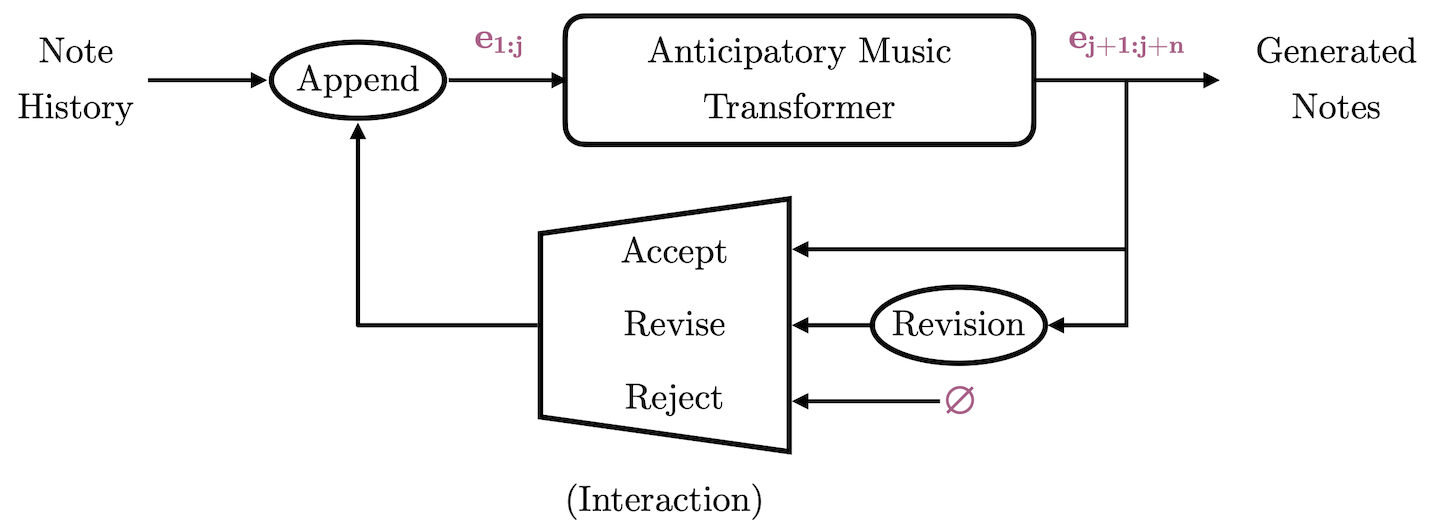

In [21]:
# Step 1: initialize the prompt (history)
history = unconditional_tokens.copy()

We prompt the model by specifying `inputs`, and ask the model to continue generating music, starting from the end of the previous prompt (`start_time=length`). In this example, we ask the model to generate an additional 5 seconds of music.

In [2]:
# Step 2: generate n seconds of music following the prompt
# re-run this cell immediate to reject the proposal
# or run the next cell to accept the proposal

n = 5

proposal = generate(model, start_time=length, end_time=length+n, inputs=history, top_p=0.98)
Audio(synthesize(fs, proposal))

NameError: name 'generate' is not defined

After generating a candidate continuation `proposal`, we can choose to either accept this proposal (running the following cell to append the proposed continuation to the prompt) or reject the proposal (run the previous cell again).

In [10]:
# Step 3: accept the proposal
history = proposal
length += n

# re-run Step 2 to continue generating music

We can save the resulting music to a MIDI file.

In [11]:
mid = events_to_midi(proposal)
mid.save('prompted.mid')

## Loading your own MIDI

You can load your own MIDI as follows. Here, we synthesize the first 30 seconds of the loaded MIDI file by clipping the loaded sequence of events. The `ops.clip` function takes a list of `events`, a `start_time`, and an `end_time`, and returns the events in the interval [`start_time`,`end_time`].



In [12]:
events = midi_to_events('examples/strawberry.mid')
Audio(synthesize(fs, ops.clip(events, 0, 30)))

fluidsynth: warning: Sample 'SineWave': ROM sample ignored
error: '-F' is an illegal option at this place, only -b option is allowed here.
fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter 'tmp.wav' not a SoundFont or MIDI file or error occurred identifying it.
error: '-r' is an illegal option at this place, only -b option is allowed here.
fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '44100' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.5.2
Copyright (C) 2000-2025 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.



ValueError: rate must be specified when data is a numpy array or list of audio samples.

Here's another example of clipping. This time, we clip 16 seconds of music starting 41 seconds into the music. The clipping operation simply discards events outside the specified region; often we will want to translate this clip to start from time 0. We can do this using `ops.translate`.

For the clip operation, we specified time in units of seconds. Time in our models is quantized at a much finer rate (10ms quantization). To be precise about timing, we can specify time using this fine-grained quantization. By specifying the `seconds=False` flag to `ops.min_time`, we retrieve the minimum time in the `segment` measured in 10ms resolution. Many of the utilities in the `ops` library provide an option time to be specified in either seconds or 100ths of a second.

In [13]:
segment = ops.clip(events, 41, 41+16)
segment = ops.translate(segment, -ops.min_time(segment, seconds=False))
Audio(synthesize(fs, segment))

fluidsynth: warning: Sample 'SineWave': ROM sample ignored
error: '-F' is an illegal option at this place, only -b option is allowed here.
fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter 'tmp.wav' not a SoundFont or MIDI file or error occurred identifying it.
error: '-r' is an illegal option at this place, only -b option is allowed here.
fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '44100' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.5.2
Copyright (C) 2000-2025 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.



ValueError: rate must be specified when data is a numpy array or list of audio samples.

### Span Infilling

We can use anticipation to infill a span of time. To do this, we treat the history (in this case, the first 6 seconds) as a prompt, and the future (the
last 5 seconds) as anticipated events. We mark anticipated events as a control by adding CONTROL_OFFSET to each item in the sequence. We can use the `ops.combine` method to recombine a sequence of events and control events.



In [14]:
history = ops.clip(segment, 0, 6, clip_duration=False)
anticipated = [CONTROL_OFFSET + tok for tok in ops.clip(segment, 11, 16, clip_duration=False)]
Audio(synthesize(fs, ops.combine(history, anticipated)))

fluidsynth: warning: Sample 'SineWave': ROM sample ignored
error: '-F' is an illegal option at this place, only -b option is allowed here.
fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter 'tmp.wav' not a SoundFont or MIDI file or error occurred identifying it.
error: '-r' is an illegal option at this place, only -b option is allowed here.
fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '44100' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.5.2
Copyright (C) 2000-2025 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.



ValueError: rate must be specified when data is a numpy array or list of audio samples.

To infill the missing span, we specify the anticipated events at the end of the span using the `controls` input to the `generate` function.

In [ ]:
inpainted = generate(model, 6, 11, inputs=history, controls=anticipated, top_p=.95)
Audio(synthesize(fs, ops.combine(inpainted, anticipated)))

### Accompaniment

Now let's see how to generate an accompaniment given a melodic line. We use the `extract_instruments` method to extract the melodic instrument (in this case, MIDI instrument code 53) from the music.

In [ ]:
segment = ops.clip(events, 41, 41+20)
segment = ops.translate(segment, -ops.min_time(segment, seconds=False))

print(ops.get_instruments(segment).keys())
events, melody = extract_instruments(segment, [53])
Audio(synthesize(fs, melody))

We are going to prompt the model using a 5-second clip from the beginning of the segment, plus the melody for the full 20-second segment. Here's what the prompt sounds like.

In [ ]:
history = ops.clip(events, 0, 5, clip_duration=False)
Audio(synthesize(fs, history + melody))

And we generate an accompaniment, conditioning on 5 seconds of `history` and accompanying the subsequent 15 seconds `melody`, which we condition on as anticipated controls.

In [ ]:
accompaniment = generate(model, 5, 20, inputs=history, controls=melody, top_p=.95, debug=False)
output = ops.clip(ops.combine(accompaniment, melody), 0, 20, clip_duration=True)
Audio(synthesize(fs, output))

## A Richer Interactive Control Flow

To create the co-compositions featured in Example 3 of the accompanying [blog post](https://crfm.stanford.edu/2023/06/14/anticipatory-music-transformer.html?idx=1#demo-example), we used a control flow that combines the iterative interaction flow described above together with melodic control inputs.

This modified control flow is illustrated by the following Figure:

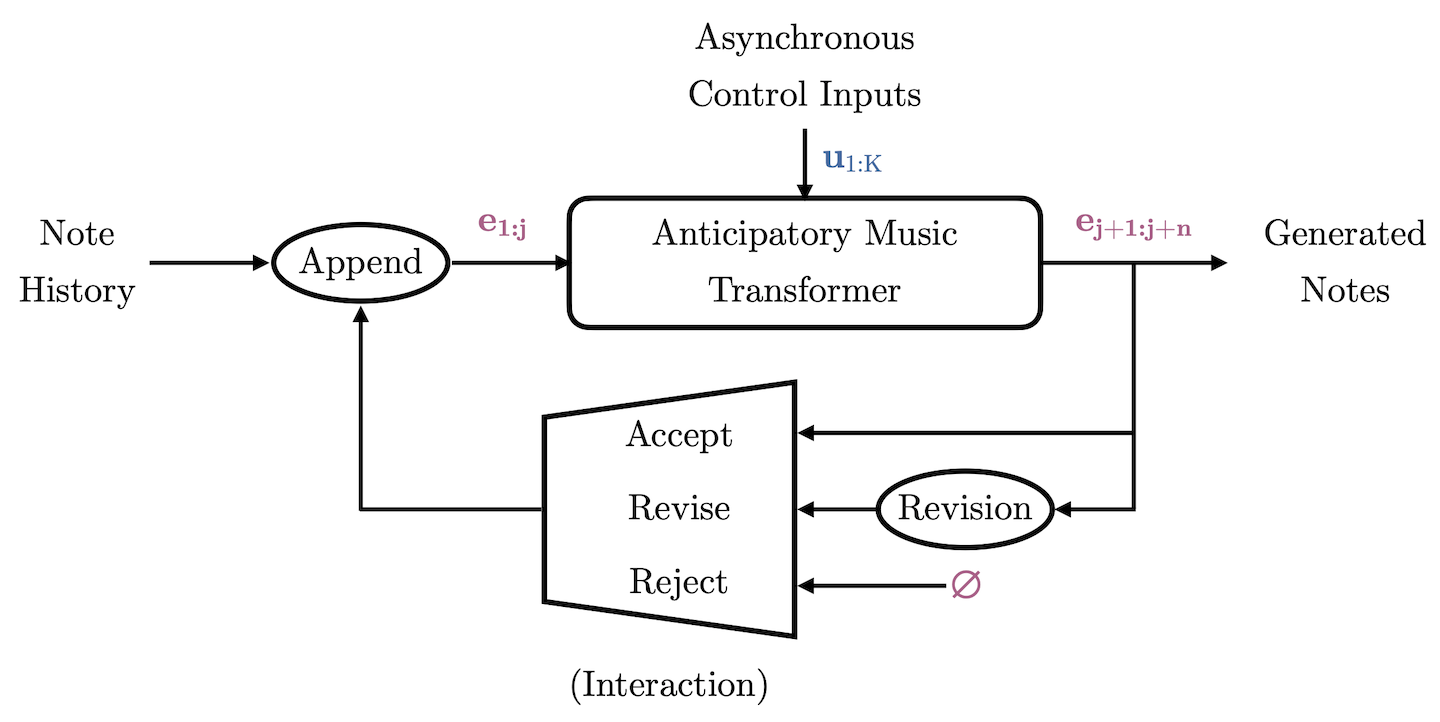

### Loading the initial note history and controls

First we load an initial MIDI to start our editing process:

In [ ]:
events = midi_to_events('anticipation/examples/strawberry.mid')
segment = ops.clip(events, 41, 41+45)
segment = ops.translate(segment, -ops.min_time(segment, seconds=False))
Audio(synthesize(fs, segment))

We extract the melody to use as control inputs:

In [ ]:
print(ops.get_instruments(segment))
events, melody = extract_instruments(segment, [53])
Audio(synthesize(fs, melody))

And we extract the first 5 seconds to use as a prompt:

In [ ]:
length = 5
prompt = ops.clip(events, 0, length, clip_duration=False)
Audio(synthesize(fs, prompt))

### The control loop

**Generate** new events (re-run this cell to reject the previous proposal)

In [ ]:
n = 5              # choose how many seconds of music to generate
nucleus_p = 0.98   # choose a nucleus sampling probability

proposal = generate(model, start_time=length, end_time=length+n, inputs=prompt, controls=melody, top_p=nucleus_p)

**Inspect** the proposed output

In [ ]:
offset = 0   # an offset for the audio preview (set this to > 0 to clip the beginning of the sequence)

output = ops.clip(ops.combine(proposal, melody), offset, length+n, clip_duration=True)
output = ops.translate(output, -ops.min_time(output, seconds=False))
Audio(synthesize(fs, output))

In [ ]:
visualize(proposal, 'output.png') # visualize the proposed generation

In [ ]:
print(ops.get_instruments(proposal)) # the number of notes for each instrument contained in the proposal

**Accept** the proposed output

In [ ]:
prompt = proposal
length += n

**Revise** the proposed output: delete an instrument from the proposed generation

In [ ]:
instr = 128
candidate = ops.delete(proposal, lambda token: (token[2]-NOTE_OFFSET)//2**7 == instr)
output = ops.clip(ops.combine(candidate, melody), 0, length+n, clip_duration=True)
Audio(synthesize(fs, output))

In [ ]:
# accept the revision
proposal = candidate

**Revise** the proposed output: revert to an earlier generation timepoint

In [ ]:
reversion = length+2
candidate = ops.clip(proposal, 0, reversion, clip_duration=False)
output = ops.clip(ops.combine(candidate, melody), 0, length+n, clip_duration=True)
Audio(synthesize(fs, candidate))

In [ ]:
# accept the revision
prompt = candidate
length = reversion

**Save** the proposed output

In [ ]:
mid = events_to_midi(proposal)
mid.save('strawberry-1.mid')